<a href="https://colab.research.google.com/github/vatsaaa/mtech/blob/main/semester_3/ADL_Group99_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1
Implement and train a conditional Wesserstein GAN with CIFAR10 dataset. Generate and display 10 new images belonging to 'automobile' class. Report IS and FID scores.

# Understanding CWGAN
Conditional Wasserstein GAN (CWGAN) extends Wasserstein GAN (WGAN) to generate class-conditional images. Instead of generating images unconditionally, the model learns to generate images conditioned on a class label.

WGAN uses the Wasserstein distance as a measure of difference between real and generated distributions, which improves stability over traditional GANs.
Conditional GAN (cGAN) conditions both the generator and discriminator on class labels.
Gradient Penalty (CWGAN-GP) is used to enforce the Lipschitz constraint instead of weight clipping.

In [1]:
# @title Ensure required libraries are installed
!pip install torch torchvision torchmetrics matplotlib numpy scipy tqdm

  Using cached torchmetrics-1.6.1-py3-none-any.whl.metadata (21 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-ma

In [2]:
# @title Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import torchvision.models as models
from scipy.linalg import sqrtm
from tqdm import tqdm

from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

Use NVIDIA T4 GPUs for this kind of large scale training tasks

In [3]:
# @title Pre-process CIFAR-10 dataset and normalize it for stable training
# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
batch_size = 64
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
# @title Define Conditional Generator that takes random noise (z) and a class label (y) as input and generates an image
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels, img_size):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, z_dim)

        self.model = nn.Sequential(
            nn.Linear(z_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_channels * img_size * img_size),
            nn.Tanh()  # Output range [-1, 1] since we normalized images
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        img = self.model(x)
        return img.view(img.shape[0], 3, 32, 32)  # Reshape to (batch, channels, height, width)

z_dim = 100
num_classes = 10
img_channels = 3
img_size = 32

gen = Generator(z_dim, num_classes, img_channels, img_size).to("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# @title Define Conditional Critic (i.e. WGAN Discriminator) that assigns a score to real and generated images, and conditions on class labels.
class Critic(nn.Module):
    def __init__(self, img_channels, img_size, num_classes):
        super(Critic, self).__init__()
        self.label_emb = nn.Embedding(num_classes, img_size * img_size)

        self.model = nn.Sequential(
            nn.Linear(img_channels * img_size * img_size + img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)  # Output a single scalar score
        )

    def forward(self, img, labels):
        img_flat = img.view(img.shape[0], -1)
        label_embedding = self.label_emb(labels)
        x = torch.cat([img_flat, label_embedding], dim=1)
        return self.model(x)

critic = Critic(img_channels, img_size, num_classes).to("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# @title Gradient Penalty Function: WGAN-GP enforces 1-Lipschitz constraint using gradient penalty instead of weight clipping
def gradient_penalty(critic, real_images, fake_images, labels, device="cuda"):
    batch_size, c, h, w = real_images.shape
    epsilon = torch.rand((batch_size, 1, 1, 1), device=device).expand_as(real_images)

    interpolated_images = (epsilon * real_images + (1 - epsilon) * fake_images).requires_grad_(True)
    mixed_scores = critic(interpolated_images, labels)

    grad_outputs = torch.ones_like(mixed_scores, device=device)
    gradients = torch.autograd.grad(
        outputs=mixed_scores, inputs=interpolated_images,
        grad_outputs=grad_outputs, create_graph=True, retain_graph=True
    )[0]

    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [7]:
# @title Define Training Procedure: Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-4
num_epochs = 200
critic_iterations = 5
lambda_gp = 10  # Gradient penalty weight

optimizer_G = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

In [8]:
# @title Define Training Procedure: Training Loop
for epoch in range(num_epochs):
    for batch_idx, (real, labels) in enumerate(train_loader):
        real, labels = real.to(device), labels.to(device)
        batch_size = real.shape[0]

        # Train Critic
        for _ in range(critic_iterations):
            noise = torch.randn(batch_size, z_dim, device=device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels)
            critic_fake = critic(fake.detach(), labels)
            gp = gradient_penalty(critic, real, fake, labels, device)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp

            optimizer_C.zero_grad()
            loss_critic.backward()
            optimizer_C.step()

        # Train Generator
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = gen(noise, labels)
        gen_loss = -torch.mean(critic(fake, labels))  # Wants to maximize critic(fake)

        optimizer_G.zero_grad()
        gen_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{num_epochs}]  Loss Critic: {loss_critic:.4f}  Loss Generator: {gen_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/2]  Loss Critic: -24.2905  Loss Generator: 0.8540
Epoch [1/2]  Loss Critic: -12.8206  Loss Generator: -10.2187


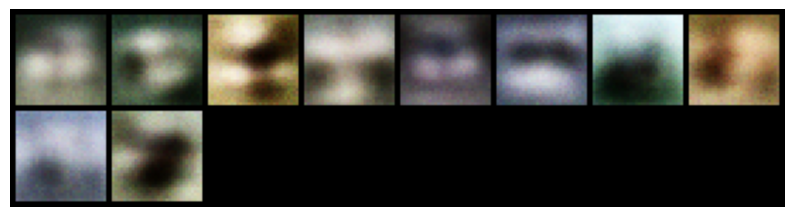

In [9]:
# @title Generate and save sample images
import torchvision.utils as vutils

def generate_images(gen, num_samples=10):
    noise = torch.randn(num_samples, z_dim, device=device)
    labels = torch.randint(0, num_classes, (num_samples,), device=device)
    with torch.no_grad():
        fake_images = gen(noise, labels)
    grid = vutils.make_grid(fake_images, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()

generate_images(gen)

## Generate and display 10 new images belonging to 'automobile' class
To generate and display 10 new images belonging to the automobile class using our trained Conditional WGAN, we need to pass the corresponding class label for "automobile" from the CIFAR-10 dataset.

CIFAR-10 Class Labels:
The class labels in CIFAR-10 are:
0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

Hence, the label we use for automobile is 1.

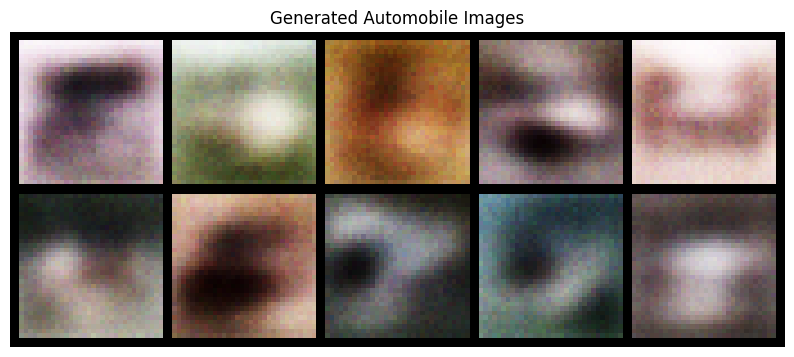

In [10]:
# @title Generate and Display Images for class 'automobile'
import torchvision.utils as vutils

def generate_automobile_images(gen, num_samples=10):
    gen.eval()  # Set generator to evaluation mode
    noise = torch.randn(num_samples, z_dim, device=device)  # Generate random noise
    labels = torch.full((num_samples,), 1, device=device)  # Class 1: automobile

    with torch.no_grad():
        fake_images = gen(noise, labels)  # Generate images

    # Convert images to grid and display
    grid = vutils.make_grid(fake_images, normalize=True, nrow=5)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Generated Automobile Images")
    plt.show()

generate_automobile_images(gen)


# Conclusion
This implementation of CWGAN-GP effectively:
- Generates class-conditional images.
- Uses Wasserstein loss for stable training.
- Uses gradient penalty to enforce Lipschitz continuity.

# Report IS and FID scores
Evaluating CWGAN-GP using Inception Score (IS) and Frechet Inception Distance (FID)
To measure the quality and diversity of generated images, we use:

Inception Score (IS) - Measures the clarity and diversity of generated images.
Frechet Inception Distance (FID) - Measures the distribution difference between real and generated images.

In [11]:
# @title Define Inception Score (IS) Calculation
# Inception Score (IS) is calculated using the pre-trained Inception v3 model. It evaluates how well the generated images belong to a specific class and how diverse they are.

def compute_inception_score(generator, num_samples=5000, batch_size=50, device="cuda"):
    generator.eval()  # Set generator to evaluation mode

    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = torch.nn.Identity()  # Remove final classification layer
    inception_model.eval()

    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Inception model requires 299x299 input
        transforms.Normalize((0.5,), (0.5,))
    ])

    all_preds = []
    with torch.no_grad():
        for _ in tqdm(range(num_samples // batch_size), desc="Computing IS"):
            noise = torch.randn(batch_size, z_dim, device=device)
            labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = generator(noise, labels)
            fake_images = transform(fake_images)

            preds = inception_model(fake_images).softmax(dim=-1)  # Get class probabilities
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    kl_div = all_preds * (np.log(all_preds) - np.log(np.expand_dims(all_preds.mean(axis=0), axis=0)))
    is_score = np.exp(kl_div.sum(axis=1).mean())

    return is_score

In [12]:
# @title Define Frechet Inception Distance (FID) Calculation
# FID measures the distributional similarity between real and generated images using the Inception v3 model.

def compute_fid(generator, real_loader, num_samples=5000, batch_size=50, device="cuda"):
    generator.eval()

    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = torch.nn.Identity()  # Remove final classification layer
    inception_model.eval()

    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Inception model requires 299x299 input
        transforms.Normalize((0.5,), (0.5,))
    ])

    def get_activations(loader, num_samples):
        activations = []
        with torch.no_grad():
            for batch_idx, (images, _) in enumerate(tqdm(loader, desc="Computing FID Real")):
                if batch_idx * batch_size >= num_samples:
                    break
                images = images.to(device)
                images = transform(images)
                activations.append(inception_model(images).cpu().numpy())
        return np.concatenate(activations, axis=0)

    def get_fake_activations(generator, num_samples):
        activations = []
        with torch.no_grad():
            for _ in tqdm(range(num_samples // batch_size), desc="Computing FID Fake"):
                noise = torch.randn(batch_size, z_dim, device=device)
                labels = torch.randint(0, num_classes, (batch_size,), device=device)
                fake_images = generator(noise, labels)
                fake_images = transform(fake_images)
                activations.append(inception_model(fake_images).cpu().numpy())
        return np.concatenate(activations, axis=0)

    real_activations = get_activations(real_loader, num_samples)
    fake_activations = get_fake_activations(generator, num_samples)

    # Compute FID Score
    mu_real, sigma_real = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = fake_activations.mean(axis=0), np.cov(fake_activations, rowvar=False)

    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))

    return fid_score

In [13]:
# @title Compute and Print Scores
# Compute Inception Score
is_score = compute_inception_score(gen, num_samples=5000, batch_size=50, device=device)
print(f"Inception Score: {is_score:.4f}")

# Compute FID Score
fid_score = compute_fid(gen, train_loader, num_samples=5000, batch_size=50, device=device)
print(f"FID Score: {fid_score:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 81.1MB/s]
Computing IS: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Inception Score: 1.0902


Computing FID Fake: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


FID Score: 152.4964


# Interpretation of Results
## Inception Score (IS)
Higher is better (good range for CIFAR-10: 7–10)
Measures image quality and class diversity.

## Frechet Inception Distance (FID)
Lower is better (good range for CIFAR-10: ≤ 40)
Measures distributional similarity between real and generated images.


# Task 2
Implement and train a SNGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

In [14]:
# @title Spectral Normalization Generative Adversarial Network (SNGAN) using the CIFAR-10 dataset

# Hyperparameters
batch_size = 128
z_dim = 128  # Dimension of the latent vector
lr = 2e-4
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# @title Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [16]:
# @title Define Generator that takes a random noise vector and generates a 32x32 image
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256*4*4),
            nn.BatchNorm1d(256*4*4),
            nn.ReLU(),

            nn.Unflatten(1, (256, 4, 4)),  # Reshape to (256,4,4)

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output image in range [-1,1]
        )

    def forward(self, z):
        return self.model(z)

In [17]:
# @title Define Discriminator with Spectral Normalization (helps to stabilize training)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1),

            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1),

            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1),

            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(256*4*4, 1))
        )

    def forward(self, x):
        return self.model(x)

In [18]:
# @title Initialize Models and Adam Optimizers for training
# Initialize models
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))

Epoch 1/50: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]


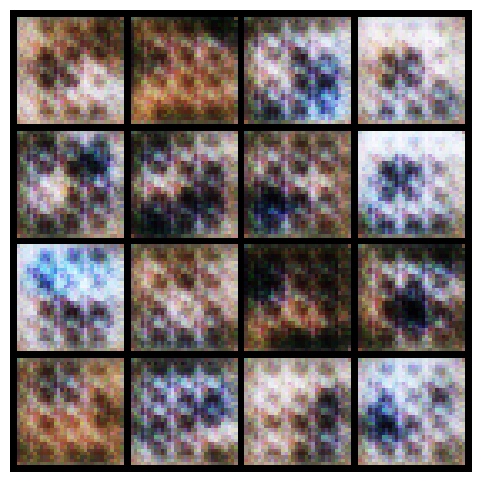

Epoch 2/50: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]


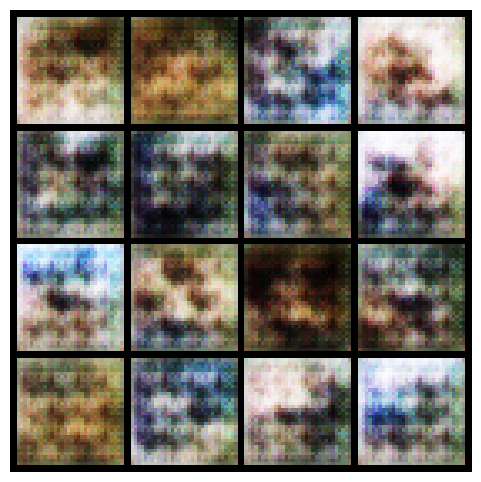

Epoch 3/50: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]


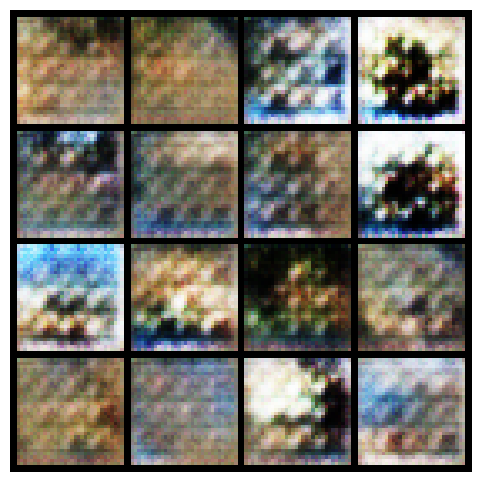

Epoch 4/50: 100%|██████████| 391/391 [00:18<00:00, 21.28it/s]


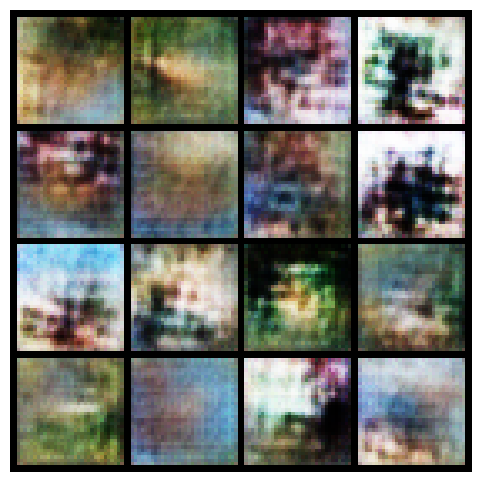

Epoch 5/50: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]


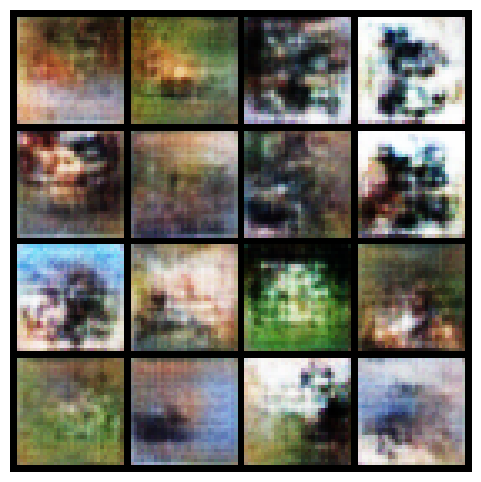

Epoch 6/50: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]


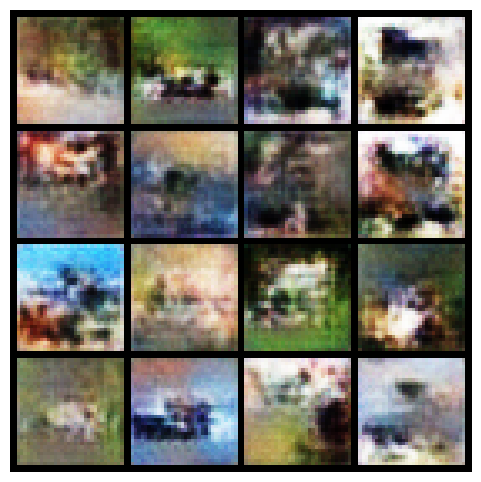

Epoch 7/50: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]


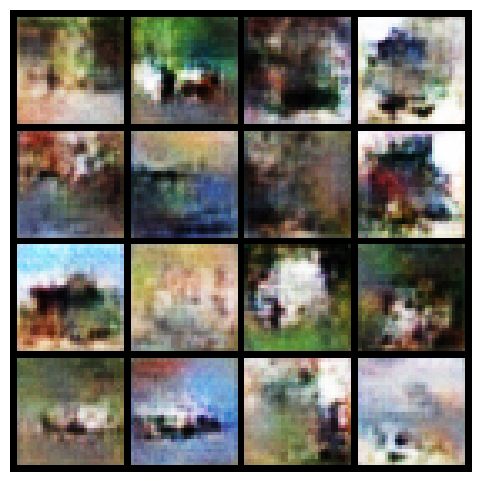

Epoch 8/50: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]


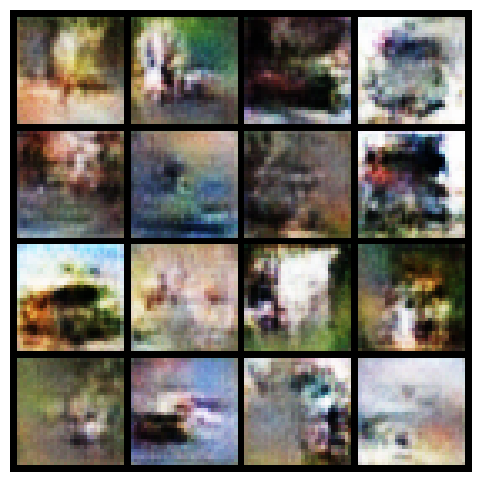

Epoch 9/50: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]


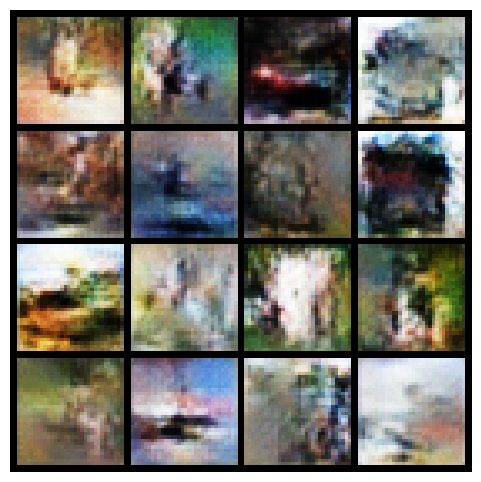

Epoch 10/50: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]


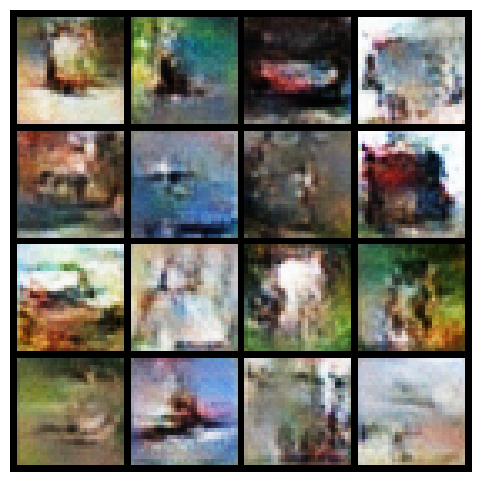

Epoch 11/50: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]


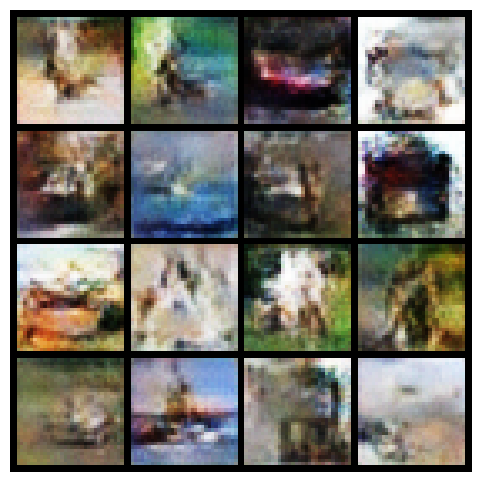

Epoch 12/50: 100%|██████████| 391/391 [00:19<00:00, 20.56it/s]


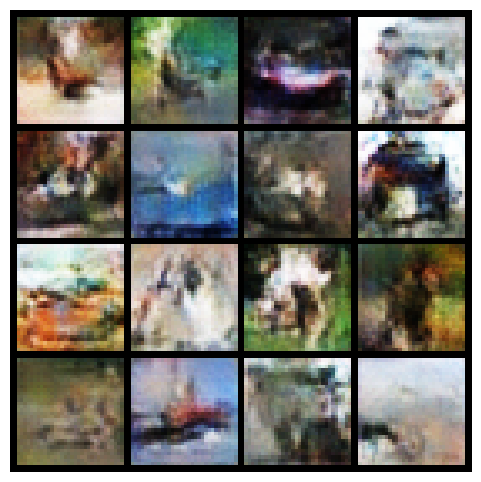

Epoch 13/50: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]


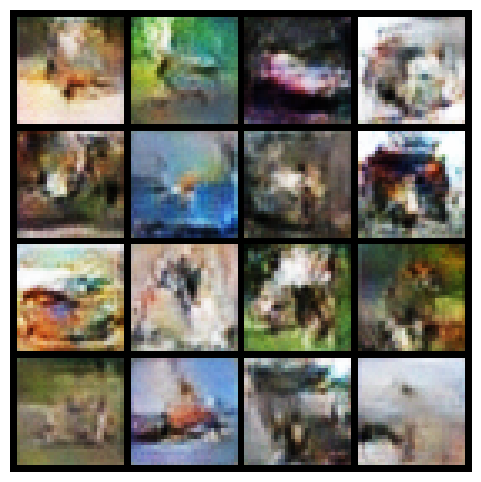

Epoch 14/50: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]


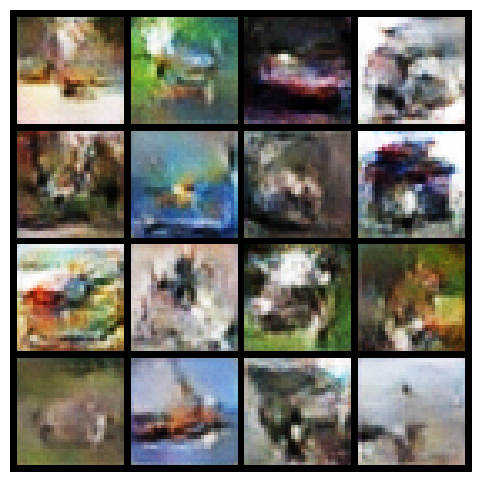

Epoch 15/50: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s]


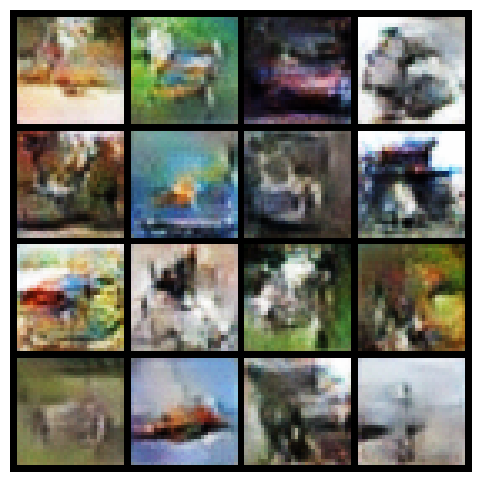

Epoch 16/50: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]


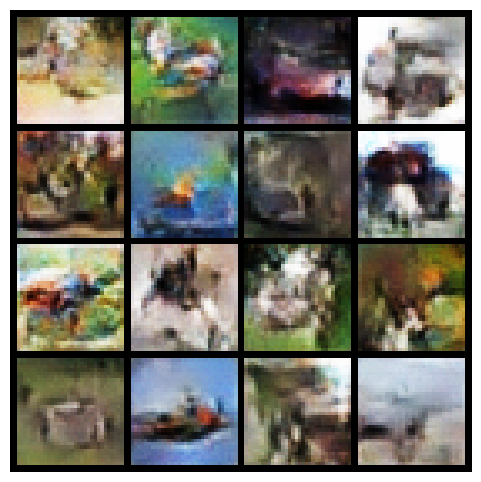

Epoch 17/50: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]


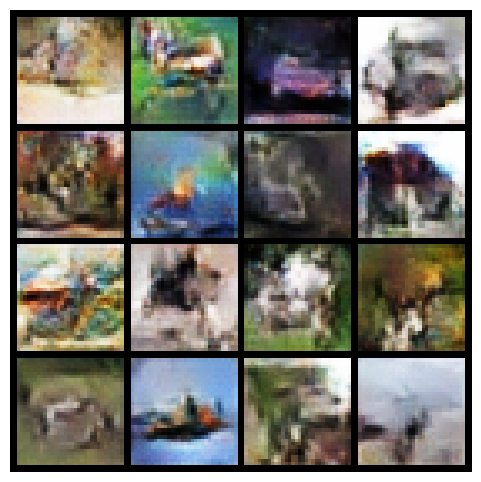

Epoch 18/50: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s]


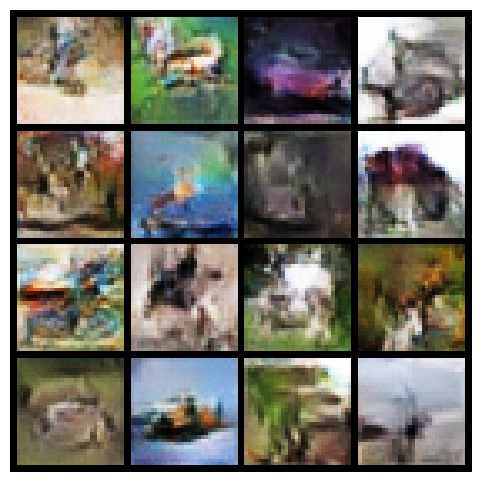

Epoch 19/50: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]


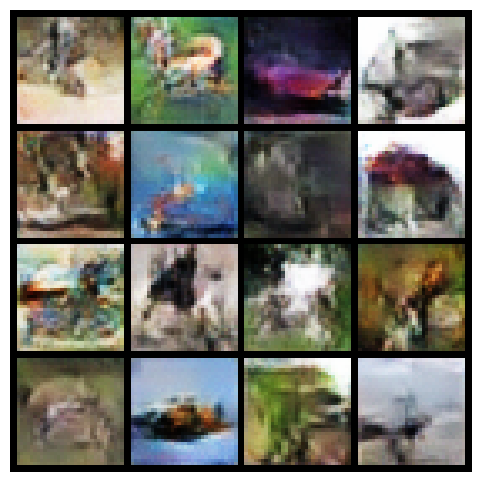

Epoch 20/50: 100%|██████████| 391/391 [00:18<00:00, 21.14it/s]


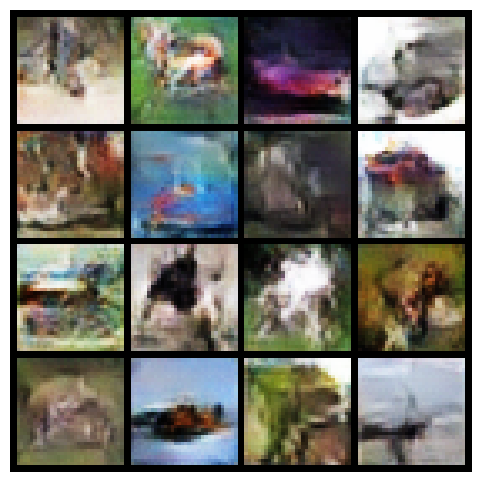

Epoch 21/50: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]


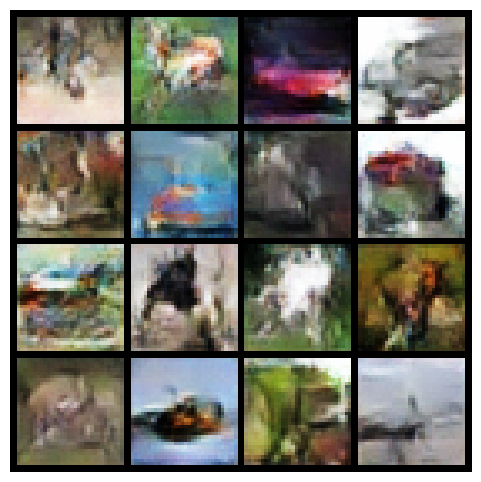

Epoch 22/50: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]


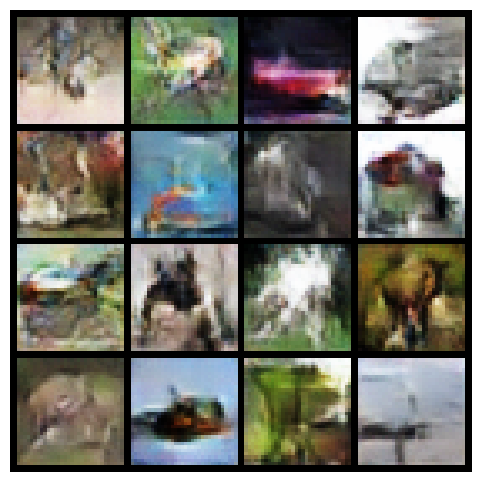

Epoch 23/50: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s]


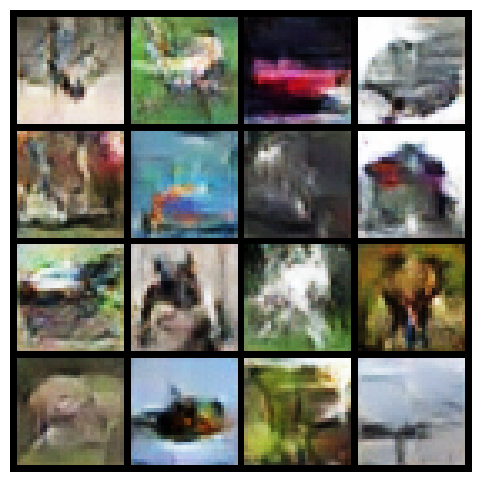

Epoch 24/50: 100%|██████████| 391/391 [00:19<00:00, 20.36it/s]


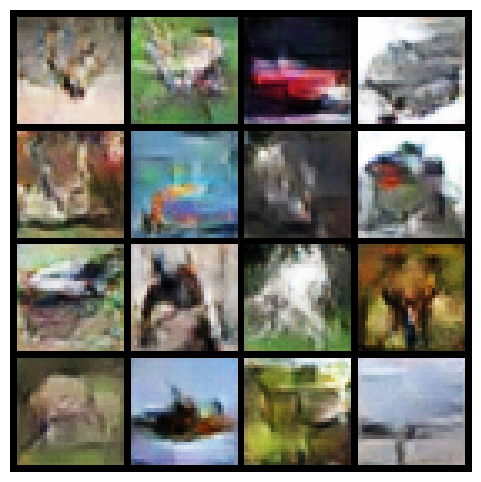

Epoch 25/50: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]


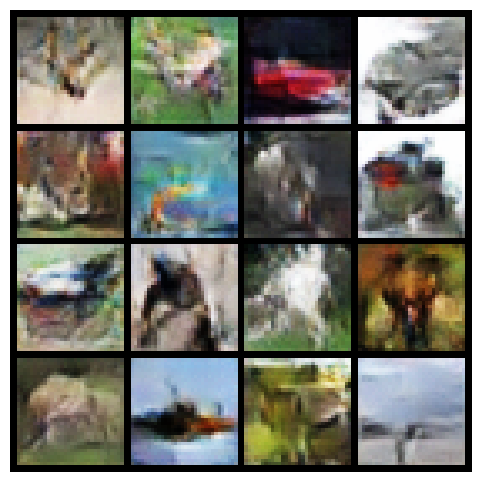

Epoch 26/50: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]


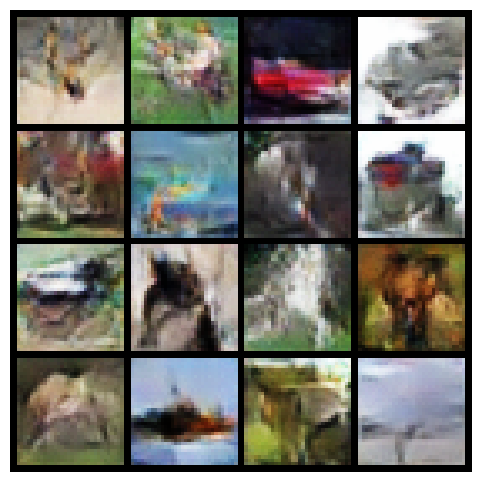

Epoch 27/50: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]


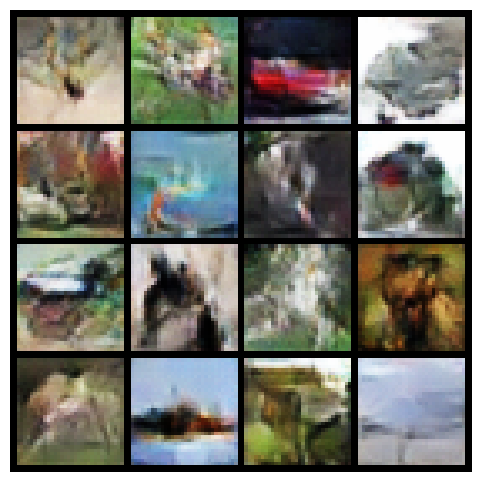

Epoch 28/50: 100%|██████████| 391/391 [00:19<00:00, 19.71it/s]


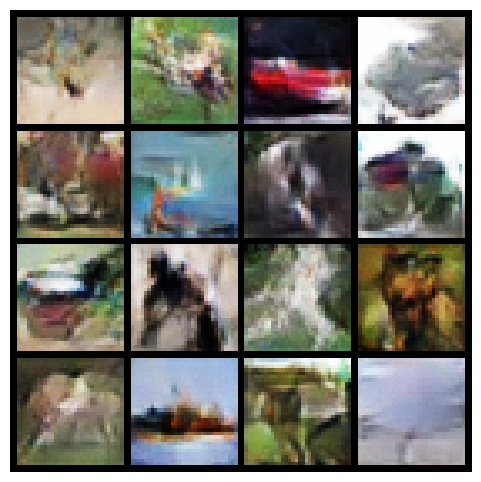

Epoch 29/50: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]


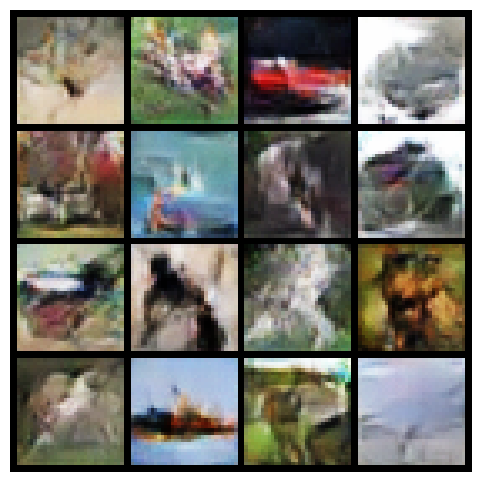

Epoch 30/50: 100%|██████████| 391/391 [00:19<00:00, 19.92it/s]


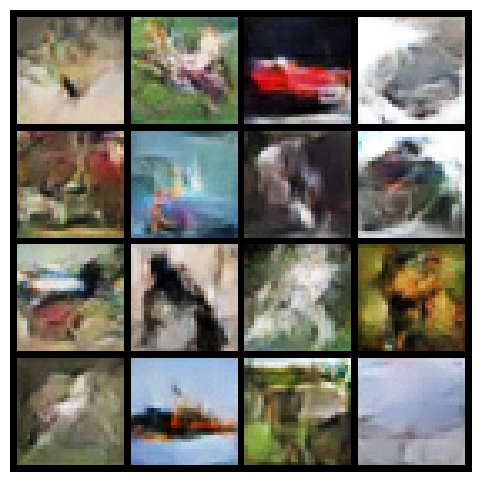

Epoch 31/50: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]


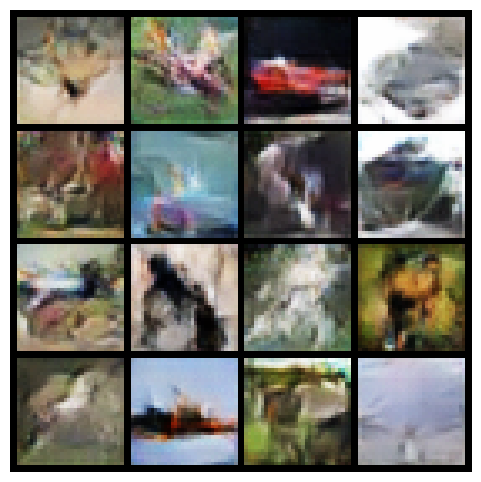

Epoch 32/50: 100%|██████████| 391/391 [00:20<00:00, 19.33it/s]


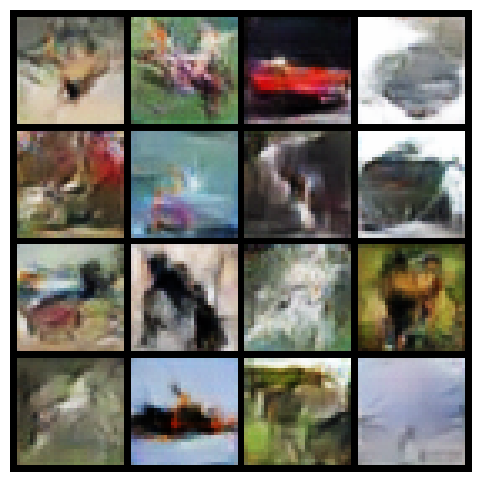

Epoch 33/50: 100%|██████████| 391/391 [00:20<00:00, 19.10it/s]


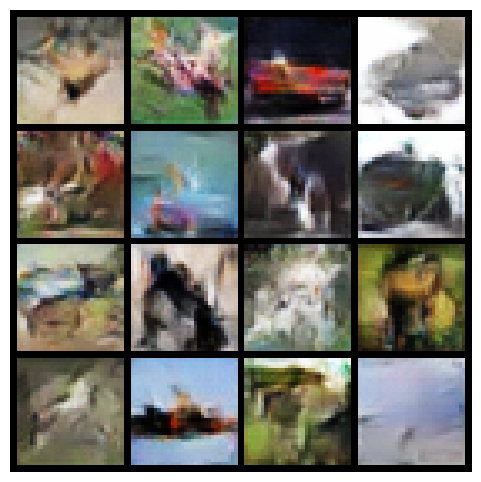

Epoch 34/50: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]


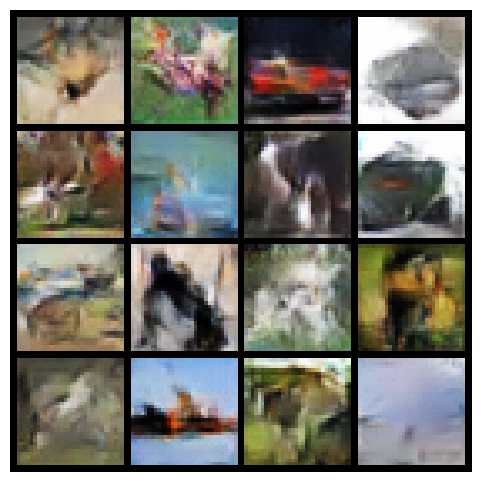

Epoch 35/50: 100%|██████████| 391/391 [00:20<00:00, 19.49it/s]


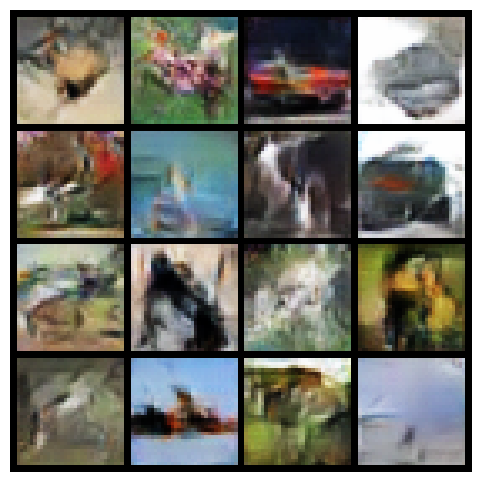

Epoch 36/50: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]


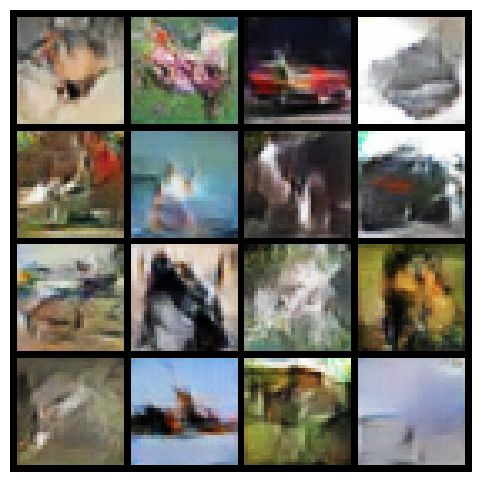

Epoch 37/50: 100%|██████████| 391/391 [00:19<00:00, 19.67it/s]


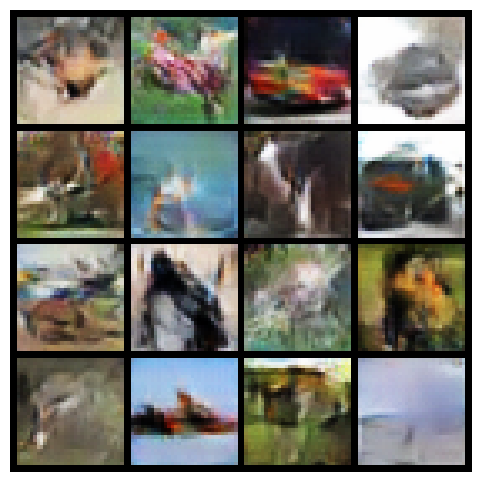

Epoch 38/50: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]


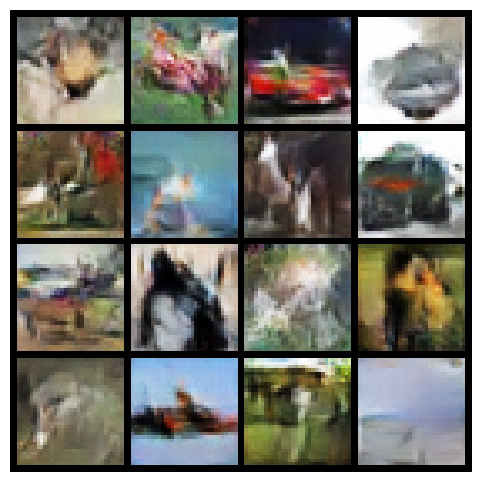

Epoch 39/50: 100%|██████████| 391/391 [00:20<00:00, 19.38it/s]


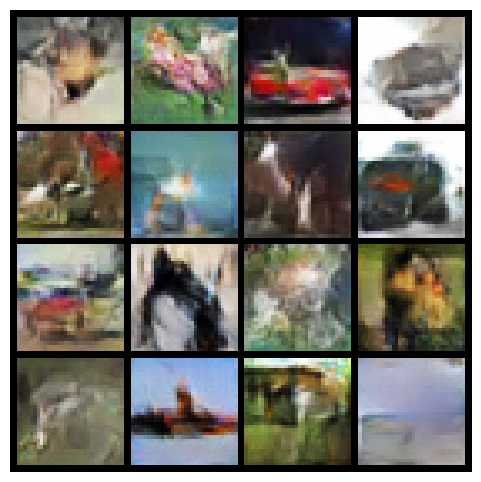

Epoch 40/50: 100%|██████████| 391/391 [00:19<00:00, 20.08it/s]


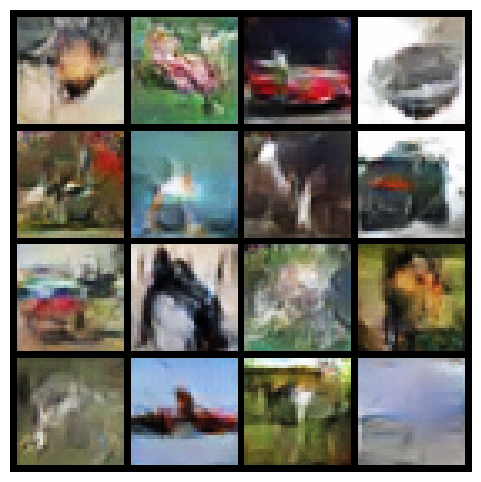

Epoch 41/50: 100%|██████████| 391/391 [00:20<00:00, 18.74it/s]


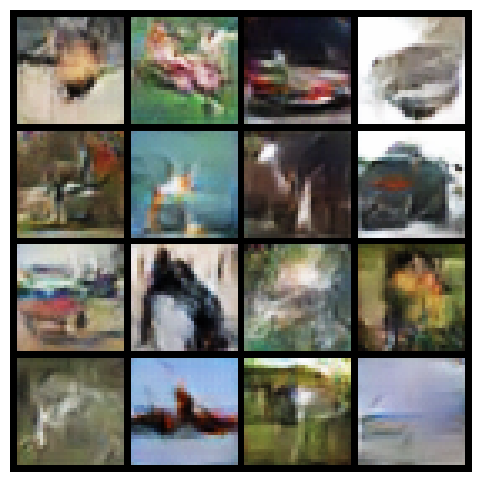

Epoch 42/50: 100%|██████████| 391/391 [00:20<00:00, 19.38it/s]


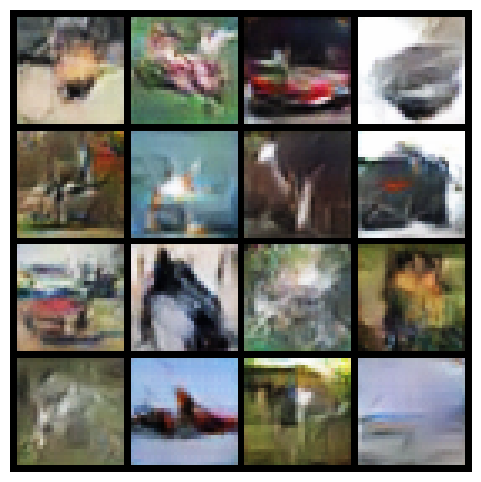

Epoch 43/50: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s]


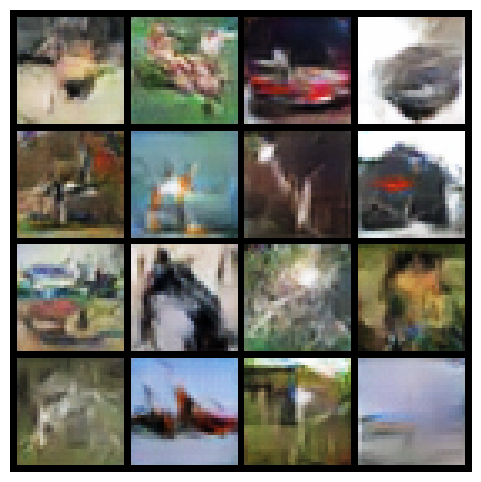

Epoch 44/50: 100%|██████████| 391/391 [00:20<00:00, 18.88it/s]


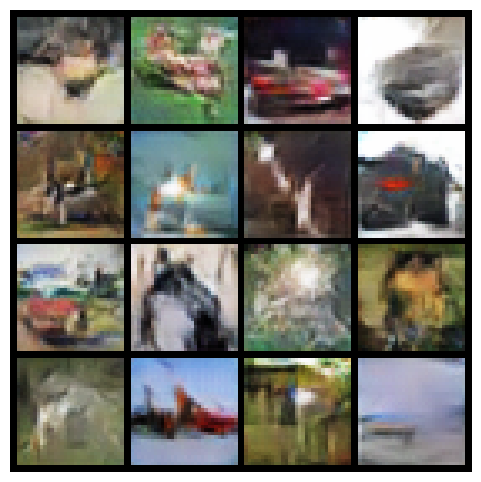

Epoch 45/50: 100%|██████████| 391/391 [00:19<00:00, 19.68it/s]


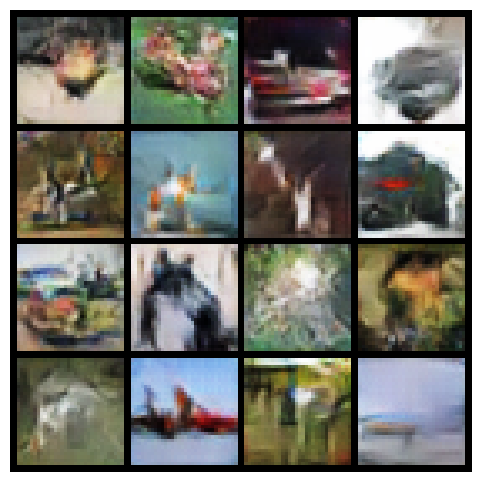

Epoch 46/50: 100%|██████████| 391/391 [00:21<00:00, 18.26it/s]


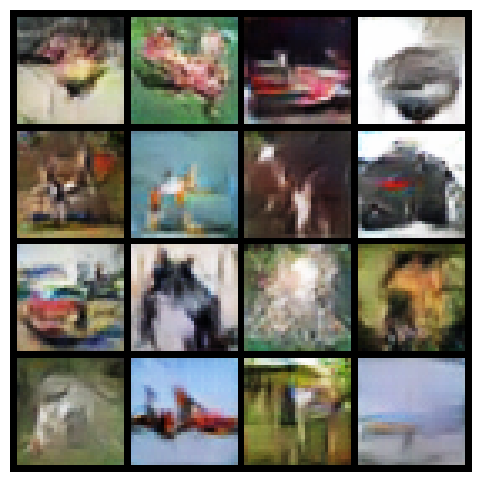

Epoch 47/50: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s]


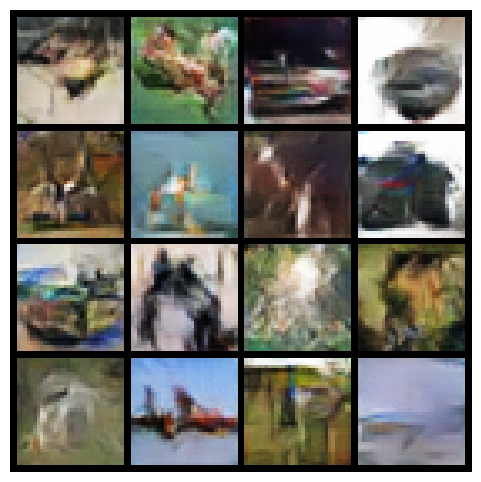

Epoch 48/50: 100%|██████████| 391/391 [00:20<00:00, 19.12it/s]


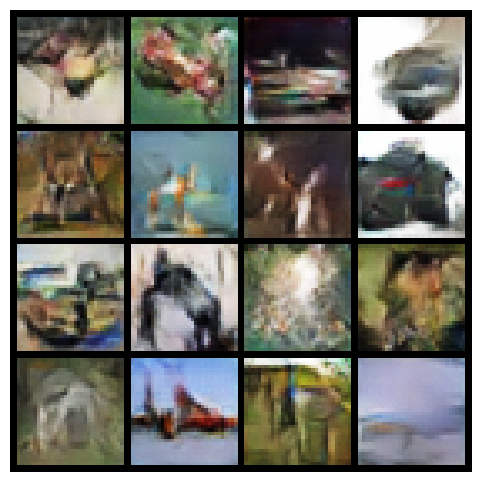

Epoch 49/50: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]


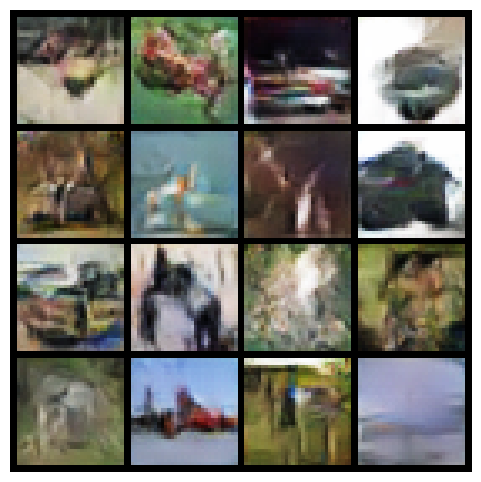

Epoch 50/50: 100%|██████████| 391/391 [00:19<00:00, 19.55it/s]


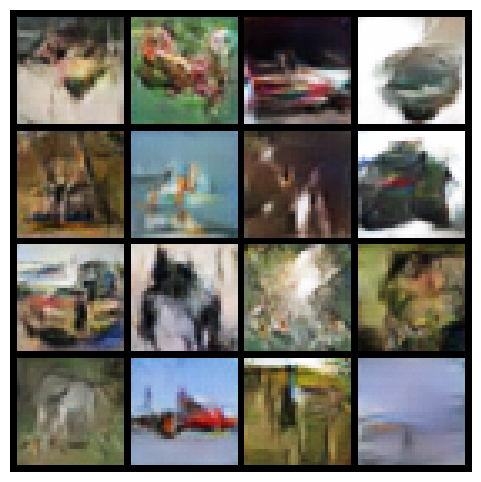

In [20]:
# @title Train the models using adversarial loss
# Fixed noise for visualization
from torchvision.utils import make_grid
fixed_noise = torch.randn(16, z_dim, device=device)

# Training loop
for epoch in range(epochs):
    for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images
        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z)

        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        g_loss = criterion(discriminator(fake_images), real_labels)  # Flip labels

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # Display progress
    with torch.no_grad():
        generated_images = generator(fixed_noise).cpu()
        generated_images = (generated_images + 1) / 2  # Denormalize to [0,1]
        grid = make_grid(generated_images, nrow=4)
        plt.figure(figsize=(6,6))
        plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
        plt.axis("off")
        plt.show()

In [ ]:
# @title Save and Load the trained generator model for later use
torch.save(generator.state_dict(), "sngan_generator.pth")
torch.save(discriminator.state_dict(), "sngan_discriminator.pth")

In [ ]:
# @title Load model for generating images
generator.load_state_dict(torch.load("sngan_generator.pth", map_location=device))
generator.eval()

In [ ]:
# @title Generate and visualize new images
with torch.no_grad():
    z = torch.randn(16, z_dim, device=device)
    fake_images = generator(z).cpu()
    fake_images = (fake_images + 1) / 2  # Convert from [-1,1] to [0,1]

    grid = make_grid(fake_images, nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis("off")
    plt.show()

# Summary of the Implementation
- Load CIFAR-10 dataset and normalize images.
- Define Generator and Discriminator, applying spectral normalization.
- Initialize models and optimizers.
- Train using adversarial loss, updating the discriminator and generator.
- Save the trained model and generate new images.

This SNGAN implementation is stable and effective for generating CIFAR-10-like images.

In [ ]:
# @title Generate and display 10 images
# Load the trained generator
generator.load_state_dict(torch.load("sngan_generator.pth", map_location=device))
generator.eval()

# Generate 10 new images
with torch.no_grad():
    z = torch.randn(10, z_dim, device=device)
    fake_images = generator(z).cpu()
    fake_images = (fake_images + 1) / 2  # Convert from [-1,1] to [0,1]

    # Display the images
    grid = make_grid(fake_images, nrow=5)  # Arrange images in a grid
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis("off")
    plt.show()

In [ ]:
# @title Compute Inception Score (IS) using the Inception v3 model. It evaluates whether generated images belong to diverse and recognizable classes.

# Load trained generator
generator.load_state_dict(torch.load("sngan_generator.pth", map_location=device))
generator.eval()

# Generate images for evaluation
num_images = 5000  # Standard number for evaluation
batch_size = 128

generated_images = []
with torch.no_grad():
    for _ in range(num_images // batch_size):
        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z).cpu()
        fake_images = (fake_images + 1) / 2  # Convert from [-1,1] to [0,1]
        generated_images.append(fake_images)

generated_images = torch.cat(generated_images)

# Compute Inception Score
is_score = InceptionScore(normalize=True)
score, std = is_score(generated_images)
print(f"Inception Score: {score:.2f} ± {std:.2f}")


In [ ]:
# @title Compute FID Score to compare generated images with real images using feature embeddings from Inception v3.
# Load real images from CIFAR-10 dataset
real_images = []
for real_batch, _ in train_loader:
    real_batch = (real_batch + 1) / 2  # Normalize to [0,1]
    real_images.append(real_batch)
    if len(real_images) * batch_size >= num_images:
        break

real_images = torch.cat(real_images)[:num_images]

# Compute FID Score
fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(generated_images, real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score:.2f}")


# Interpreting the Results
## Inception Score (IS):
Higher is better (e.g., CIFAR-10 real images score ~11).
Measures image diversity and class-specific confidence.

## FID Score:
Lower is better (real CIFAR-10 vs. itself has FID ≈ 0).
Measures similarity between generated and real images.

# Task 3
Implement and train a variant of SAGAN without spectral normalization and TTUB  with CIFAR10 dataset. Generate 10 new images. Report IS and FID scores.

# Task 4
Implement and train a complete SAGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

# Task 5
Summarize your observations.